# Mortgage Calcualations
André Guerra<br>
August, 20205

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
TICKSFONT = 13; TITLEFONT = 15; FIGWIDTH = 6.4
FIGHEIGHT = 4.8; LINEWIDTH = 3


## Mortgage Parameters and Summary Analysis

In [2]:
# mortgage porameters
home_price = 500_000
interest_rate = 0.045
loan_term = 30
down_payment_rate = 0.20
down_payment = down_payment_rate * home_price
loan_amount = home_price - down_payment

# minimum down payment requires mortgage insurance
mortgage_insurance_rate = 0.04  # annual mortgage insurance rate
if down_payment_rate < 0.20:
    annual_mortgage_insurance = mortgage_insurance_rate * loan_amount
else:
    annual_mortgage_insurance = 0

# additional costs
annual_property_tax = 6_200         # annual property tax
annual_home_insurance = 1_500       # annual home insurance
monthly_hoa = 0                     # monthly HOA fees
monthly_maintenance = 0             # monthly maintenance costs


# amortization schedule
payment_schedule = pd.date_range(start='2026-01-01', periods=loan_term * 12, freq='M')
monthly_interest_rate = interest_rate / 12
last_balance = np.zeros(loan_term * 12)
new_balance = np.zeros(loan_term * 12)
monthly_interest = np.zeros(loan_term * 12)
monthly_principal = np.zeros(loan_term * 12)

# contstant monthly payment
monthly_payment = npf.pmt(rate=monthly_interest_rate, nper=loan_term * 12, pv=-loan_amount, fv=0, when='end')

# amortization calculation
for i in range(loan_term * 12):
    if i == 0:
        last_balance[i] = loan_amount
    else:
        last_balance[i] = new_balance[i - 1]

    monthly_interest[i] = last_balance[i] * monthly_interest_rate
    monthly_principal[i] = monthly_payment - monthly_interest[i]
    new_balance[i] = last_balance[i] - monthly_principal[i]
    
# combine into a dataframe
amortization_df = pd.DataFrame({
    'Payment Date': payment_schedule,
    'Beginning Balance': last_balance,
    'Monthly Payment': monthly_payment,
    'Principal': monthly_principal,
    'Interest': monthly_interest,
    'Ending Balance': new_balance,
    'Cumulative Interest': np.cumsum(monthly_interest),
    'Cumulative Principal': np.cumsum(monthly_principal),
    'Cumulative Payment': np.cumsum(np.full(loan_term * 12, monthly_payment))
})
amortization_df.set_index('Payment Date', inplace=True)
amortization_df.index = amortization_df.index.to_period('M')
amortization_df = amortization_df.round(2)


## Summary Table

In [3]:
# summary table
print(f"\n{'='*60}"
      f"\nLOAN INFORMATION" 
      f"\n{'='*60}"
      f"\nHome Price: ${home_price:,.2f}"
      f"\nDown Payment: ${down_payment:,.2f} ({down_payment_rate*100:.1f}%)"
      f"\nLoan Amount: ${loan_amount:,.2f}"
      f"\nInterest Rate: {interest_rate*100:.3f}%"
      f"\nMonthly Interest Rate: {monthly_interest_rate*100:.3f}%"
      f"\nLoan Term: {loan_term} years"
      f"\nAmortization Periods: {loan_term*12} months"
      f"\n{'='*60}"
      f"\nLOAN PAYBACK & INTEREST ANALYSIS" 
      f"\n{'='*60}"
      f"\nMonthly Payment: ${monthly_payment:,.2f}"
      f"\nTotal Payment: ${monthly_payment*loan_term*12:,.2f}"
      f"\nTotal Interest: ${monthly_payment*loan_term*12 - loan_amount:,.2f}"
      f"\nTotal Interest Rate: {(monthly_payment*loan_term*12 - loan_amount)/loan_amount*100:.3f}%"
      f"\nInterest Multiplier: {(monthly_payment*loan_term*12)/loan_amount:.3f}x"
      f"\n{'='*60}"
      )


LOAN INFORMATION
Home Price: $500,000.00
Down Payment: $100,000.00 (20.0%)
Loan Amount: $400,000.00
Interest Rate: 4.500%
Monthly Interest Rate: 0.375%
Loan Term: 30 years
Amortization Periods: 360 months
LOAN PAYBACK & INTEREST ANALYSIS
Monthly Payment: $2,026.74
Total Payment: $729,626.85
Total Interest: $329,626.85
Total Interest Rate: 82.407%
Interest Multiplier: 1.824x


In [4]:
amortization_df.tail()

,Beginning Balance,Monthly Payment,Principal,Interest,Ending Balance,Cumulative Interest,Cumulative Principal,Cumulative Payment
Payment Date,,,,,,,,
2055-08,10020.69,2026.74,1989.16,37.58,8031.53,329551.41,391968.47,721519.88
2055-09,8031.53,2026.74,1996.62,30.12,6034.91,329581.53,393965.09,723546.62
2055-10,6034.91,2026.74,2004.11,22.63,4030.80,329604.16,395969.20,725573.36
2055-11,4030.80,2026.74,2011.63,15.12,2019.17,329619.27,397980.83,727600.10
2055-12,2019.17,2026.74,2019.17,7.57,-0.00,329626.85,400000.00,729626.85


## Visualization

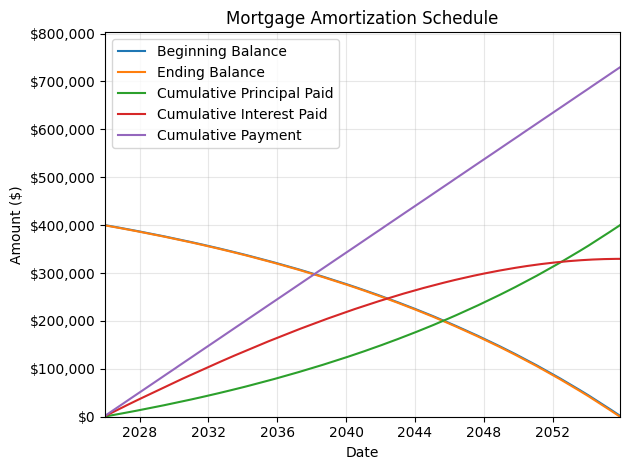

In [5]:
# plot the amortization schedule
plt.figure(figsize=(1 * FIGWIDTH, 1 * FIGHEIGHT))
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Beginning Balance'], label='Beginning Balance')
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Ending Balance'], label='Ending Balance')
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Principal'].cumsum(), label='Cumulative Principal Paid')
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Interest'].cumsum(), label='Cumulative Interest Paid')
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Cumulative Payment'], label='Cumulative Payment')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.title('Mortgage Amortization Schedule')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.xlim(amortization_df.index.to_timestamp().min(), amortization_df.index.to_timestamp().max())
plt.ylim(0, amortization_df['Cumulative Payment'].max() * 1.1)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/mortgage_amortization_schedule.png', dpi=300)

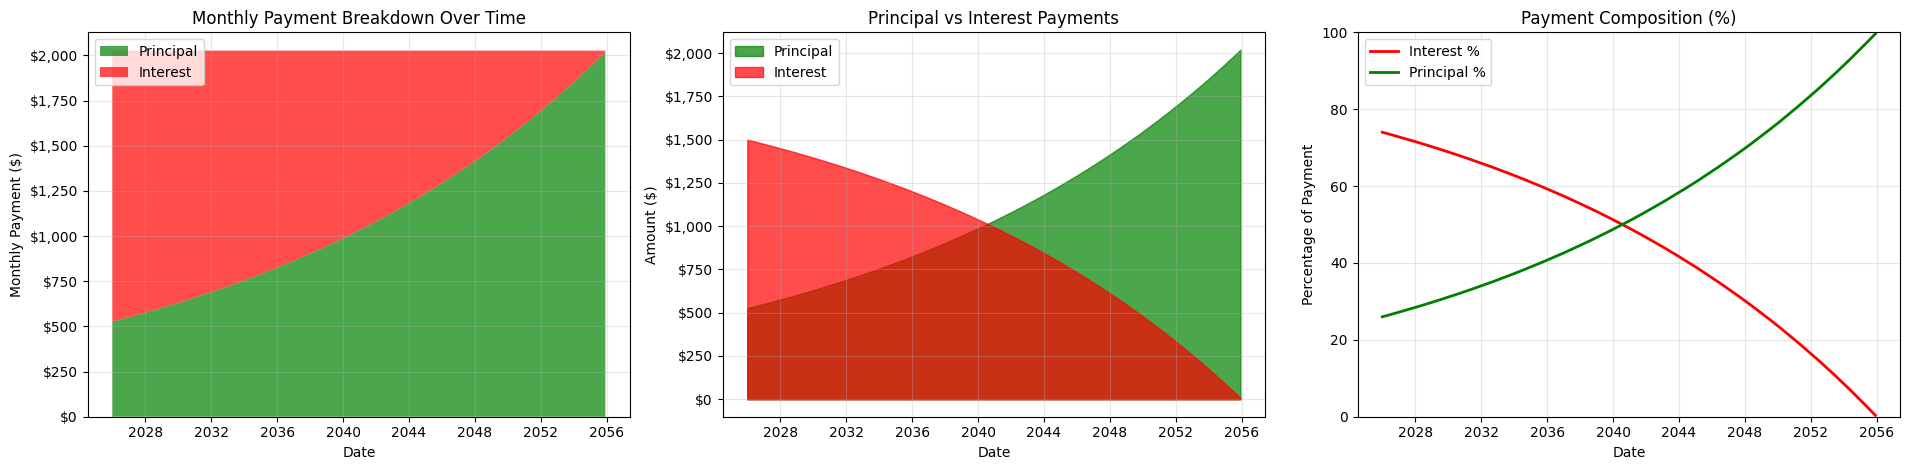

In [6]:
# 1. Principal vs Interest Monthly Breakdown
plt.figure(figsize=(3 * FIGWIDTH, FIGHEIGHT))

plt.subplot(1, 3, 1)
plt.stackplot(amortization_df.index.to_timestamp(), 
              amortization_df['Principal'], 
              amortization_df['Interest'],
              labels=['Principal', 'Interest'],
              alpha=0.7, colors=['green', 'red'])
plt.title('Monthly Payment Breakdown Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Payment ($)')
plt.legend(loc='upper left')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.fill_between(amortization_df.index.to_timestamp(), 
                 amortization_df['Principal'], 
                 label='Principal', alpha=0.7, color='green')
plt.fill_between(amortization_df.index.to_timestamp(), 
                 amortization_df['Interest'], 
                 label='Interest', alpha=0.7, color='red')
plt.title('Principal vs Interest Payments')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend(loc='upper left')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
interest_percentage = (amortization_df['Interest'] / monthly_payment) * 100
principal_percentage = (amortization_df['Principal'] / monthly_payment) * 100
plt.plot(amortization_df.index.to_timestamp(), interest_percentage, 
         label='Interest %', color='red', linewidth=2)
plt.plot(amortization_df.index.to_timestamp(), principal_percentage, 
         label='Principal %', color='green', linewidth=2)
plt.title('Payment Composition (%)')
plt.xlabel('Date')
plt.ylabel('Percentage of Payment')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('figures/mortgage_amortization_analysis.png', dpi=300)

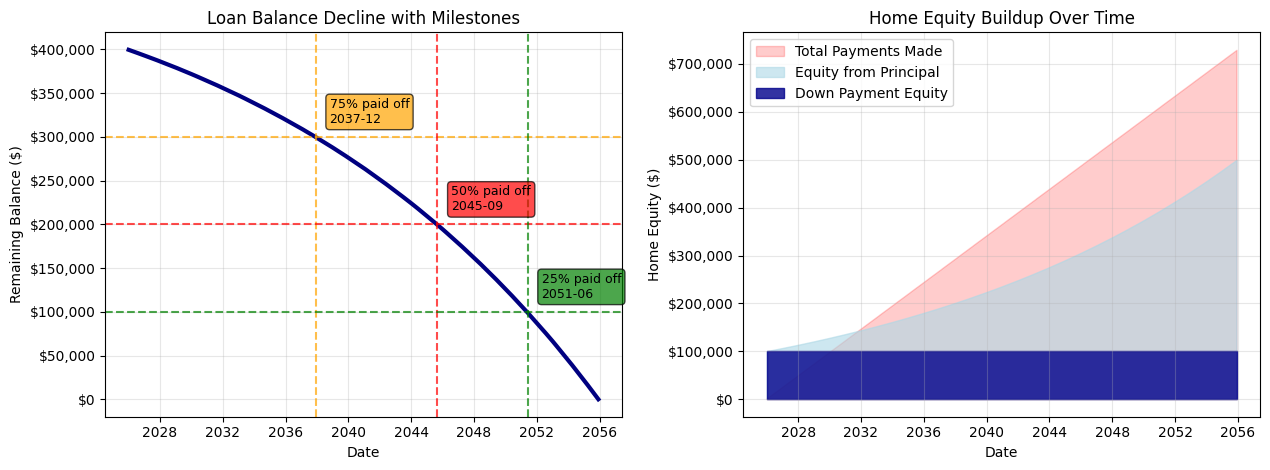

In [7]:
# 2. Loan Balance Decline with Milestones
plt.figure(figsize=(2 *FIGWIDTH, FIGHEIGHT))

plt.subplot(1, 2, 1)
plt.plot(amortization_df.index.to_timestamp(), amortization_df['Ending Balance'], 
         linewidth=3, color='navy')

# Add milestone markers
milestones = [0.75, 0.5, 0.25]
colors = ['orange', 'red', 'green']
for i, milestone in enumerate(milestones):
    milestone_balance = loan_amount * milestone
    milestone_idx = amortization_df[amortization_df['Ending Balance'] <= milestone_balance].index[0]
    milestone_date = milestone_idx.to_timestamp()
    plt.axhline(y=milestone_balance, color=colors[i], linestyle='--', alpha=0.7)
    plt.axvline(x=milestone_date, color=colors[i], linestyle='--', alpha=0.7)
    plt.annotate(f'{milestone*100:.0f}% paid off\n{milestone_date.strftime("%Y-%m")}', 
                xy=(milestone_date, milestone_balance),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7),
                fontsize=9)

plt.title('Loan Balance Decline with Milestones')
plt.xlabel('Date')
plt.ylabel('Remaining Balance ($)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Equity buildup
home_equity = home_price - amortization_df['Ending Balance']
plt.fill_between(amortization_df.index.to_timestamp(), 
                 amortization_df['Cumulative Payment'], 
                 alpha=0.2, color='red', label='Total Payments Made')
plt.fill_between(amortization_df.index.to_timestamp(), 
                 home_equity, 
                 alpha=0.6, color='lightblue', label='Equity from Principal')
plt.fill_between(amortization_df.index.to_timestamp(), 
                 down_payment, 
                 alpha=0.8, color='darkblue', label='Down Payment Equity')
plt.title('Home Equity Buildup Over Time')
plt.xlabel('Date')
plt.ylabel('Home Equity ($)')
plt.legend(loc='upper left')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/mortgage_equity_buildup.png', dpi=300)


MORTGAGE SUMMARY STATISTICS
Total cost of home: $829,626.85
Interest as % of home price: 65.9%
Average monthly cost: $2,304.52
Breakeven point (50% equity): 2042-03
Interest paid in first 5 years: $86,236.14
Principal paid in first 5 years: $35,368.33


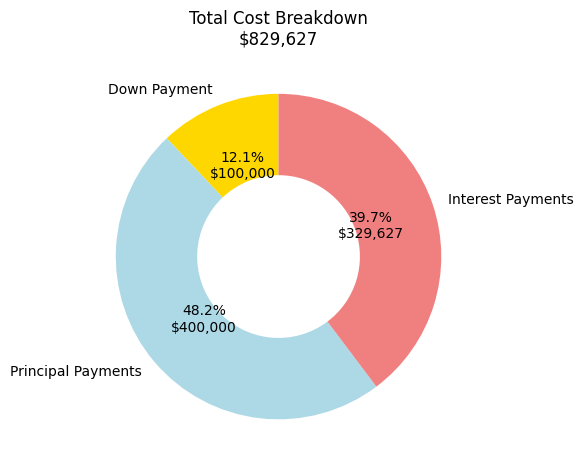

In [8]:
# 5. ROI and Cost Analysis
plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))

# Calculate additional metrics
total_cost = amortization_df['Cumulative Payment'].iloc[-1] + down_payment
cost_per_month = total_cost / (loan_term * 12)
interest_as_percentage_of_home = (amortization_df['Cumulative Interest'].iloc[-1] / home_price) * 100

# Cost breakdown donut chart
costs = [down_payment, 
         amortization_df['Cumulative Principal'].iloc[-1], 
         amortization_df['Cumulative Interest'].iloc[-1]]
labels = ['Down Payment', 'Principal Payments', 'Interest Payments']
colors = ['gold', 'lightblue', 'lightcoral']

def autopct_format(pct):
    absolute = round(pct/100.*sum(costs))
    return f'{pct:.1f}%\n${absolute:,}'

wedges, texts, autotexts = plt.pie(costs, labels=labels, autopct=autopct_format, 
                                  colors=colors, startangle=90,
                                  wedgeprops=dict(width=0.5))
plt.title(f'Total Cost Breakdown\n${total_cost:,.0f}')
plt.tight_layout()
plt.savefig('figures/mortgage_cost_breakdown.png', dpi=300)

# Print summary statistics
print(f"\n{'='*50}")
print(f"MORTGAGE SUMMARY STATISTICS")
print(f"{'='*50}")
print(f"Total cost of home: ${total_cost:,.2f}")
print(f"Interest as % of home price: {interest_as_percentage_of_home:.1f}%")
print(f"Average monthly cost: ${cost_per_month:,.2f}")
print(f"Breakeven point (50% equity): {amortization_df[home_equity >= home_price * 0.5].index[0]}")
print(f"Interest paid in first 5 years: ${amortization_df['Cumulative Interest'].iloc[59]:,.2f}")
print(f"Principal paid in first 5 years: ${amortization_df['Cumulative Principal'].iloc[59]:,.2f}")

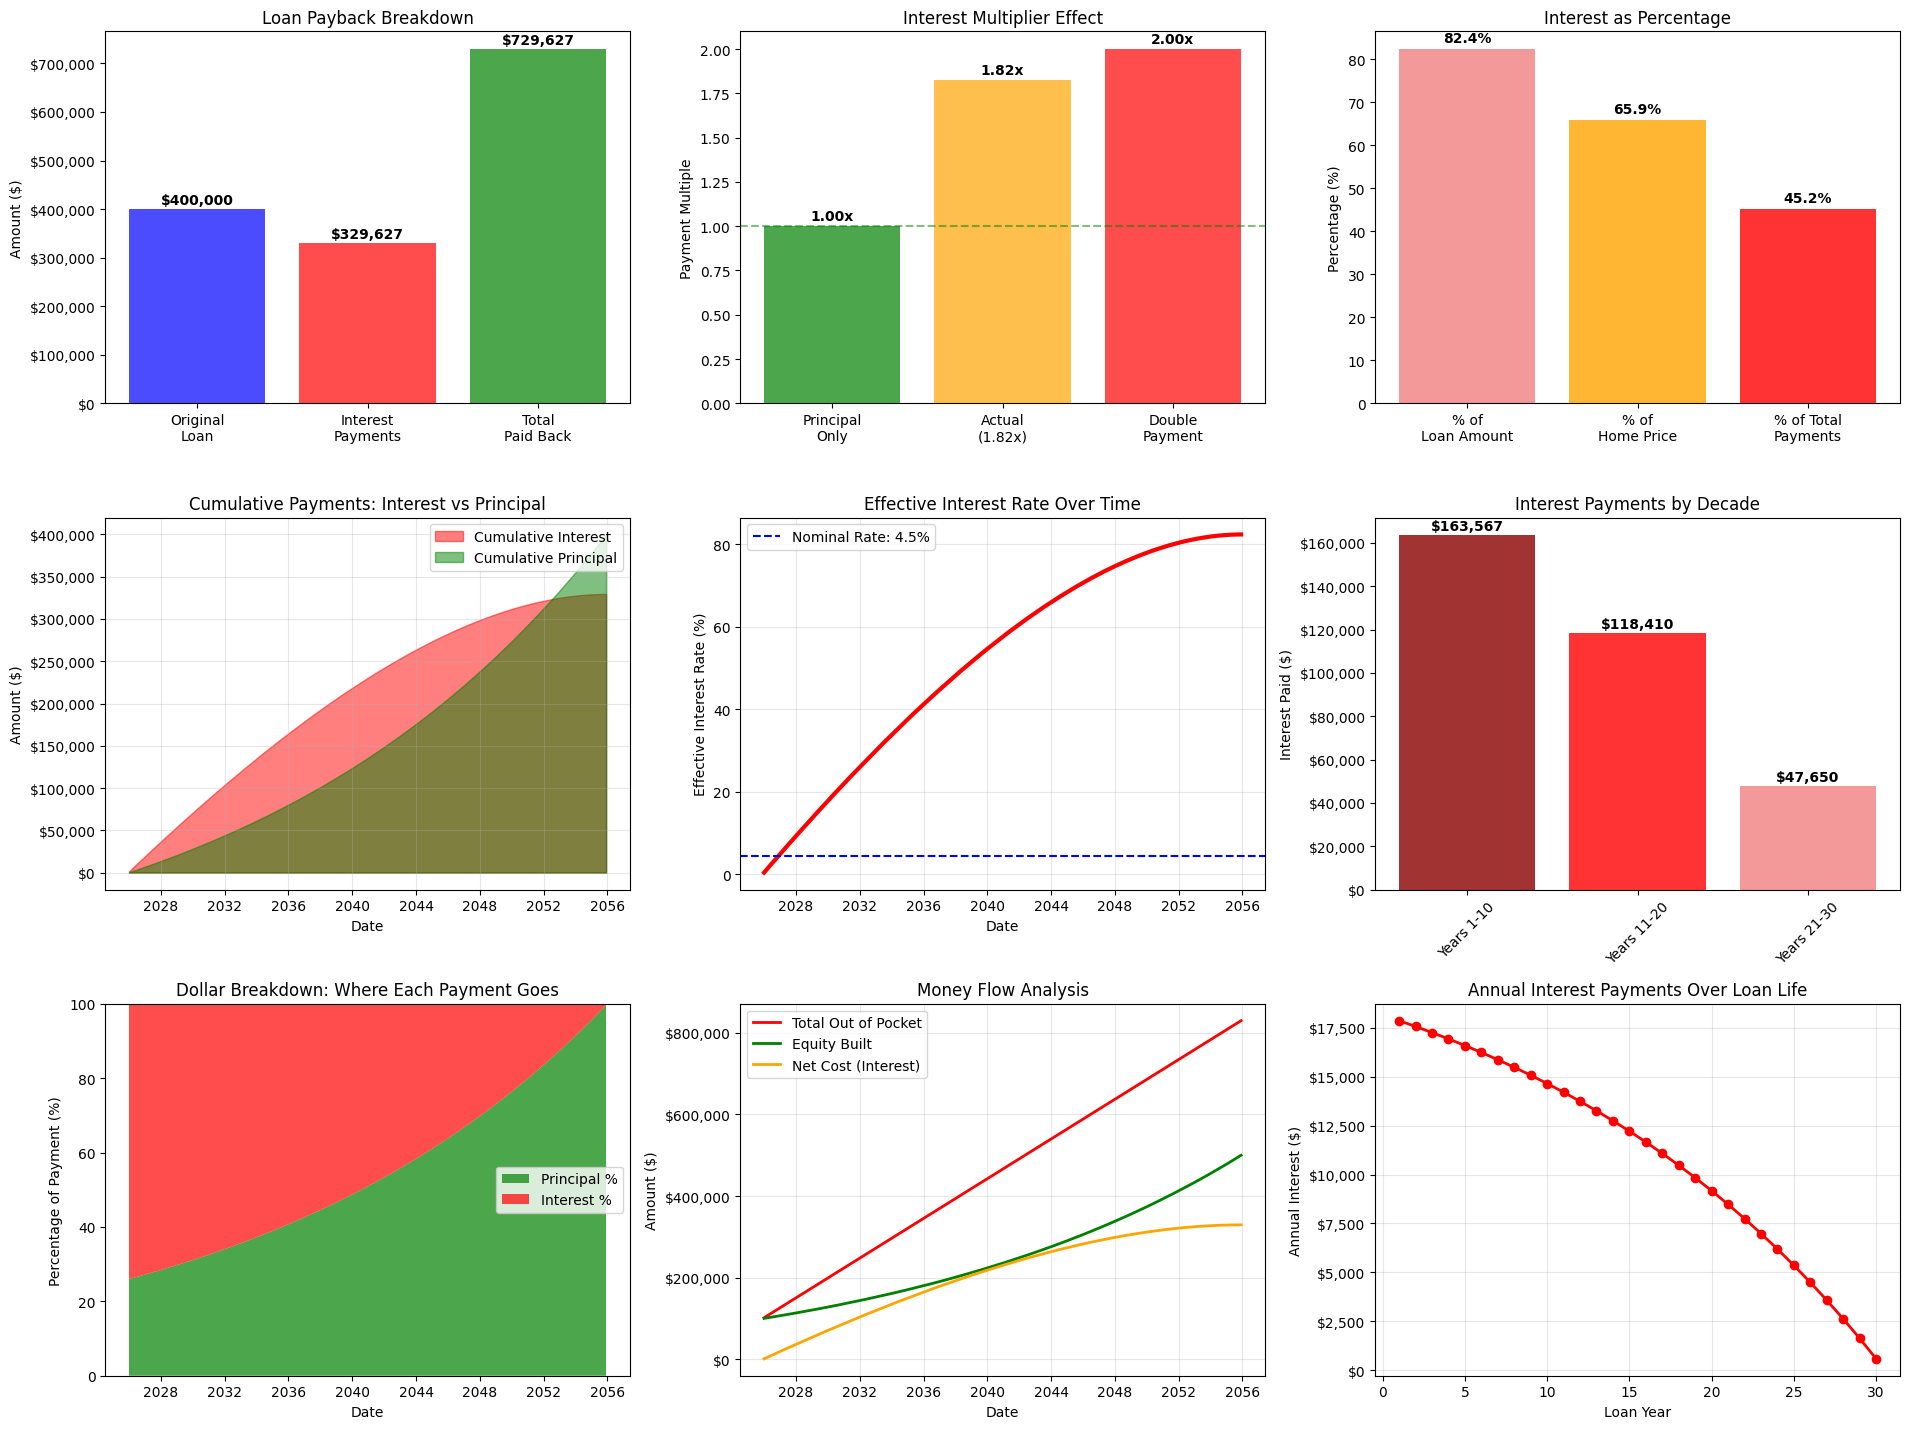

In [9]:
# 6. Total Payback and Interest Analysis
plt.figure(figsize=(3 * FIGWIDTH, 3 * FIGHEIGHT))

# Calculate key metrics
total_payments = amortization_df['Cumulative Payment'].iloc[-1]
total_interest = amortization_df['Cumulative Interest'].iloc[-1]
interest_multiplier = total_payments / loan_amount

# Top row - 3 charts
plt.subplot(3, 3, 1)
# Waterfall chart showing total cost breakdown
categories = ['Original\nLoan', 'Interest\nPayments', 'Total\nPaid Back']
values = [loan_amount, total_interest, total_payments]
colors = ['blue', 'red', 'green']
bars = plt.bar(categories, values, color=colors, alpha=0.7)
plt.title('Loan Payback Breakdown')
plt.ylabel('Amount ($)')
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'${value:,.0f}', ha='center', va='bottom', fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.subplot(3, 3, 2)
# Interest multiplier gauge
multipliers = [1.0, interest_multiplier, 2.0]
labels = ['Principal\nOnly', f'Actual\n({interest_multiplier:.2f}x)', 'Double\nPayment']
colors = ['green', 'orange', 'red']
bars = plt.bar(labels, multipliers, color=colors, alpha=0.7)
plt.title('Interest Multiplier Effect')
plt.ylabel('Payment Multiple')
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Break-even')
for bar, mult in zip(bars, multipliers):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{mult:.2f}x', ha='center', va='bottom', fontweight='bold')

plt.subplot(3, 3, 3)
# Interest as percentage of different metrics
interest_metrics = [
    (total_interest / loan_amount) * 100,
    (total_interest / home_price) * 100,
    (total_interest / total_payments) * 100
]
metric_labels = ['% of\nLoan Amount', '% of\nHome Price', '% of Total\nPayments']
bars = plt.bar(metric_labels, interest_metrics, color=['lightcoral', 'orange', 'red'], alpha=0.8)
plt.title('Interest as Percentage')
plt.ylabel('Percentage (%)')
for bar, pct in zip(bars, interest_metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Middle row - 3 charts
plt.subplot(3, 3, 4)
# Cumulative interest vs principal over time
plt.fill_between(amortization_df.index.to_timestamp(), 
                 amortization_df['Cumulative Interest'], 
                 label='Cumulative Interest', alpha=0.5, color='red')
plt.fill_between(amortization_df.index.to_timestamp(), 
                 amortization_df['Cumulative Principal'], 
                 label='Cumulative Principal', alpha=0.5, color='green')
plt.title('Cumulative Payments: Interest vs Principal')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.subplot(3, 3, 5)
# Running interest rate (interest paid / amount borrowed)
running_interest_rate = (amortization_df['Cumulative Interest'] / loan_amount) * 100
plt.plot(amortization_df.index.to_timestamp(), running_interest_rate, 
         linewidth=3, color='red')
plt.axhline(y=interest_rate * 100, color='blue', linestyle='--', 
           label=f'Nominal Rate: {interest_rate*100:.1f}%')
plt.title('Effective Interest Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Effective Interest Rate (%)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 3, 6)
# Interest burden by decade
decades = np.arange(0, loan_term, 10)
decade_labels = [f'Years {d+1}-{min(d+10, loan_term)}' for d in decades]
decade_interest = []
for d in decades:
    start_idx = d * 12
    end_idx = min((d + 10) * 12, len(amortization_df))
    decade_int = amortization_df['Interest'].iloc[start_idx:end_idx].sum()
    decade_interest.append(decade_int)

bars = plt.bar(decade_labels, decade_interest, color=['darkred', 'red', 'lightcoral'][:len(decades)], alpha=0.8)
plt.title('Interest Payments by Decade')
plt.ylabel('Interest Paid ($)')
plt.xticks(rotation=45)
for bar, interest in zip(bars, decade_interest):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'${interest:,.0f}', ha='center', va='bottom', fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Bottom row - 3 charts
plt.subplot(3, 3, 7)
# Dollar-for-dollar breakdown over time
dollar_breakdown = pd.DataFrame({
    'Principal': amortization_df['Principal'],
    'Interest': amortization_df['Interest']
})
dollar_breakdown_pct = dollar_breakdown.div(dollar_breakdown.sum(axis=1), axis=0) * 100
plt.stackplot(amortization_df.index.to_timestamp(),
              dollar_breakdown_pct['Principal'],
              dollar_breakdown_pct['Interest'],
              labels=['Principal %', 'Interest %'],
              colors=['green', 'red'], alpha=0.7)
plt.title('Dollar Breakdown: Where Each Payment Goes')
plt.xlabel('Date')
plt.ylabel('Percentage of Payment (%)')
plt.legend(loc='center right')
plt.ylim(0, 100)

plt.subplot(3, 3, 8)
# Total money out of pocket over time
total_out_of_pocket = amortization_df['Cumulative Payment'] + down_payment
equity_built = home_price - amortization_df['Ending Balance']
net_cost = total_out_of_pocket - equity_built

plt.plot(amortization_df.index.to_timestamp(), total_out_of_pocket, 
         label='Total Out of Pocket', linewidth=2, color='red')
plt.plot(amortization_df.index.to_timestamp(), equity_built, 
         label='Equity Built', linewidth=2, color='green')
plt.plot(amortization_df.index.to_timestamp(), net_cost, 
         label='Net Cost (Interest)', linewidth=2, color='orange')
plt.title('Money Flow Analysis')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.grid(alpha=0.3)

plt.subplot(3, 3, 9)
# Interest paid per year of the loan
years_range = range(1, loan_term + 1)
annual_interest_by_year = []
for year in years_range:
    start_idx = (year - 1) * 12
    end_idx = min(year * 12, len(amortization_df))
    year_interest = amortization_df['Interest'].iloc[start_idx:end_idx].sum()
    annual_interest_by_year.append(year_interest)

plt.plot(years_range, annual_interest_by_year, marker='o', linewidth=2, color='red')
plt.title('Annual Interest Payments Over Loan Life')
plt.xlabel('Loan Year')
plt.ylabel('Annual Interest ($)')
plt.grid(alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('figures/mortgage_payback_interest_analysis.png', dpi=300)

In [10]:
# Summary statistics focused on payback and interest
print(f"\n{'='*60}")
print(f"LOAN PAYBACK & INTEREST ANALYSIS")
print(f"{'='*60}")
print(f"Original loan amount:           ${loan_amount:,.2f}")
print(f"Total amount paid back:         ${total_payments:,.2f}")
print(f"Total interest paid:            ${total_interest:,.2f}")
print(f"Interest as % of loan:          {(total_interest/loan_amount)*100:.1f}%")
print(f"Interest multiplier:            {interest_multiplier:.2f}x")
print(f"For every $1 borrowed, paid:    ${interest_multiplier:.2f}")
print(f"\nFirst 10 years interest:        ${amortization_df['Interest'].iloc[:120].sum():,.2f}")
print(f"Last 10 years interest:         ${amortization_df['Interest'].iloc[-120:].sum():,.2f}")
print(f"Interest front-loading ratio:   {amortization_df['Interest'].iloc[:120].sum() / amortization_df['Interest'].iloc[-120:].sum():.1f}:1")


LOAN PAYBACK & INTEREST ANALYSIS
Original loan amount:           $400,000.00
Total amount paid back:         $729,626.85
Total interest paid:            $329,626.85
Interest as % of loan:          82.4%
Interest multiplier:            1.82x
For every $1 borrowed, paid:    $1.82

First 10 years interest:        $163,566.66
Last 10 years interest:         $47,650.07
Interest front-loading ratio:   3.4:1


In [11]:
def update_readme_with_mortgage_analysis():
    """Update README.md with current mortgage analysis results"""
    
    # Calculate all the metrics from the mortgage analysis
    total_payments = monthly_payment * loan_term * 12
    total_interest = total_payments - loan_amount
    interest_multiplier = total_payments / loan_amount
    total_cost = amortization_df['Cumulative Payment'].iloc[-1] + down_payment
    cost_per_month = total_cost / (loan_term * 12)
    interest_as_percentage_of_home = (amortization_df['Cumulative Interest'].iloc[-1] / home_price) * 100
    
    # Calculate equity milestones
    home_equity = home_price - amortization_df['Ending Balance']
    breakeven_50_equity = amortization_df[home_equity >= home_price * 0.5].index[0]
    
    # Calculate decade analysis
    first_10_years_interest = amortization_df['Interest'].iloc[:120].sum()
    last_10_years_interest = amortization_df['Interest'].iloc[-120:].sum()
    interest_front_loading_ratio = first_10_years_interest / last_10_years_interest
    
    # Generate the analysis section
    analysis_section = f"""
<!-- AUTO-GENERATED MORTGAGE ANALYSIS START -->
## 🏠 Mortgage Analysis Results

### Key Financial Metrics
- **Total Interest Cost**: ${total_interest:,.0f}
- **Interest Multiplier**: {interest_multiplier:.2f}x (pay ${interest_multiplier:.2f} for every $1 borrowed)
- **Total Home Cost**: ${total_cost:,.0f}

### Loan Parameters
| Parameter | Value |
|-----------|-------|
| 🏠 **Home Price** | ${home_price:,.2f} |
| 💰 **Down Payment** | ${down_payment:,.2f} ({down_payment_rate*100:.1f}%) |
| 📊 **Loan Amount** | ${loan_amount:,.2f} |
| 📈 **Interest Rate** | {interest_rate*100:.2f}% |
| ⏰ **Loan Term** | {loan_term} years |
| 💳 **Monthly Payment** | ${monthly_payment:,.2f} |

### Cost Breakdown Analysis
| Metric | Amount | Percentage |
|--------|--------|------------|
| **Original Loan** | ${loan_amount:,.2f} | {(loan_amount/total_cost)*100:.1f}% of total cost |
| **Interest Payments** | ${total_interest:,.2f} | {(total_interest/loan_amount)*100:.1f}% of loan |
| **Down Payment** | ${down_payment:,.2f} | {(down_payment/total_cost)*100:.1f}% of total cost |
| **Total Home Cost** | ${total_cost:,.2f} | {interest_as_percentage_of_home:.1f}% above home price |

### Payment Analysis
| Timeframe | Interest Paid | Key Insight |
|-----------|---------------|-------------|
| **First 10 Years** | ${first_10_years_interest:,.2f} | Front-loaded interest period |
| **Last 10 Years** | ${last_10_years_interest:,.2f} | Principal-heavy period |
| **Front-Loading Ratio** | {interest_front_loading_ratio:.1f}:1 | Early years pay {interest_front_loading_ratio:.1f}x more interest |

### Equity & Milestones
| Milestone | Timeline | Details |
|-----------|----------|---------|
| **50% Equity Point** | {breakeven_50_equity} | Break-even point for home equity |
| **Average Monthly Cost** | ${cost_per_month:,.2f} | Total cost ÷ {loan_term} years |
| **Interest as % of Home** | {interest_as_percentage_of_home:.1f}% | Interest relative to home value |

### 📊 Summary Statistics
```
Loan Information:
├── Home Price:                 ${home_price:,.2f}
├── Down Payment:               ${down_payment:,.2f} ({down_payment_rate*100:.1f}%)
├── Loan Amount:                ${loan_amount:,.2f}
├── Interest Rate:              {interest_rate*100:.3f}%
└── Monthly Payment:            ${monthly_payment:,.2f}

Payback Analysis:
├── Total Amount Paid:          ${total_payments:,.2f}
├── Total Interest:             ${total_interest:,.2f}
├── Interest Multiplier:        {interest_multiplier:.2f}x
├── Interest % of Loan:         {(total_interest/loan_amount)*100:.1f}%
└── For every $1 borrowed:      Pay ${interest_multiplier:.2f}

Cost Distribution:
├── First 5 Years Interest:     ${amortization_df['Cumulative Interest'].iloc[59]:,.2f}
├── First 5 Years Principal:    ${amortization_df['Cumulative Principal'].iloc[59]:,.2f}
├── Early Interest Burden:      {(amortization_df['Cumulative Interest'].iloc[59]/total_interest)*100:.1f}% of total
└── Early Principal Progress:   {(amortization_df['Cumulative Principal'].iloc[59]/loan_amount)*100:.1f}% of loan
```

### 🎯 Key Insights
- **Interest Front-Loading**: You pay **{interest_front_loading_ratio:.1f}x more interest** in the first 10 years compared to the last 10 years
- **True Cost**: The home actually costs **${total_cost:,.0f}** ({interest_as_percentage_of_home:.1f}% more than the list price)
- **Interest Burden**: Interest represents **{(total_interest/total_cost)*100:.1f}%** of your total home cost
- **Break-Even**: You'll own 50% equity in **{breakeven_50_equity}**

*Last updated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}*
<!-- AUTO-GENERATED MORTGAGE ANALYSIS END -->
"""

    # Read existing README
    try:
        with open('README.md', 'r') as f:
            readme_content = f.read()
    except FileNotFoundError:
        readme_content = "# Financial Analysis\n\n"
    
    # Replace or add analysis section
    start_marker = "<!-- AUTO-GENERATED MORTGAGE ANALYSIS START -->"
    end_marker = "<!-- AUTO-GENERATED MORTGAGE ANALYSIS END -->"
    
    if start_marker in readme_content and end_marker in readme_content:
        # Replace existing section
        start_idx = readme_content.find(start_marker)
        end_idx = readme_content.find(end_marker) + len(end_marker)
        readme_content = readme_content[:start_idx] + analysis_section + readme_content[end_idx:]
    else:
        # Append new section
        readme_content += "\n" + analysis_section
    
    # Write updated README
    with open('README.md', 'w') as f:
        f.write(readme_content)
    
    print("✅ README.md updated with latest mortgage analysis results")

# Run the update
update_readme_with_mortgage_analysis()

✅ README.md updated with latest mortgage analysis results


In [12]:
def update_readme_with_executive_summary():
    """Update README.md with an executive summary of the mortgage analysis"""
    
    loan_to_value_ratio = (loan_amount / home_price) * 100
    breakeven_50_equity = amortization_df[home_equity >= home_price * 0.5].index[0]
    
    # Generate the executive summary section
    executive_summary = f"""
<!-- AUTO-GENERATED SUMMARY START -->
## 🏠 Mortgage Analysis Executive Summary

### Loan Overview
- **Home Price**: ${home_price:,.2f}
- **Down Payment**: ${down_payment:,.2f} ({down_payment_rate*100:.1f}%)
- **Loan Amount**: ${loan_amount:,.2f}
- **Interest Rate**: {interest_rate*100:.3f}%
- **Loan Term**: {loan_term} years
- **Monthly Payment**: ${monthly_payment:,.2f}
### Financial Summary
- **Average Monthly Cost**: ${cost_per_month:,.2f}
- **Total Interest Paid**: ${total_interest:,.2f}
- **Total Payments Made**: ${total_payments:,.2f}
- **Total Home Cost**: ${total_cost:,.2f}
- **Interest as % of Home Price**: {interest_as_percentage_of_home:.1f}%
- **Loan-to-Home Price Ratio**: {loan_to_value_ratio:.2f}%
- **Break-even Point**: {breakeven_50_equity}

### Recommendations
*TODO*

### Conclusion
*TODO*

*Last updated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}*
<!-- AUTO-GENERATED SUMMARY END -->
"""

    # Read existing README
    try:
        with open('README.md', 'r') as f:
            readme_content = f.read()
    except FileNotFoundError:
        readme_content = "# Financial Analysis\n\n"
    
    # Replace or add executive summary section
    start_marker = "<!-- AUTO-GENERATED SUMMARY START -->"
    end_marker = "<!-- AUTO-GENERATED SUMMARY END -->"
    
    if start_marker in readme_content and end_marker in readme_content:
        # Replace existing section
        start_idx = readme_content.find(start_marker)
        end_idx = readme_content.find(end_marker) + len(end_marker)
        readme_content = readme_content[:start_idx] + executive_summary + readme_content[end_idx:]
    else:
        # Append new section
        readme_content += "\n" + executive_summary
    
    # Write updated README
    with open('README.md', 'w') as f:
        f.write(readme_content)
    
    print("✅ README.md updated with latest executive summary")
    
# Run the update
update_readme_with_executive_summary()

✅ README.md updated with latest executive summary
